In [1]:
%load_ext autoreload
%autoreload 2

The goal of this notebook is to use the re-created code from the old Repo to get the same graph.

It'll be taking the original implementations and tweaking them to get it working

In [2]:
import json
import torch
from tqdm import tqdm
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt

from repeng import DatasetEntry
from repeng.reading_pipeline import RepReading


/workspace/repeng/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available()else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", legacy=False) # Wonder what padding left does
tokenizer.pad_token_id = 0 

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


In [5]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1

# TODO: replicate this pipeline implementation
# rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [6]:
# Directly taken from new code - not using old dataset at all. Consider trying out old dataset if this is a problem
user_tag, asst_tag = "[INST]", "[/INST]"
with open("data/true_facts.json") as f:
    suffixes = json.load(f)

# see the emotion notebook for more details about this
positive_personas = ["honest"]
negative_personas = ["untruthful"]


def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"


dataset: list[DatasetEntry] = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# print some example entries
print(dataset[1])
for i in range(3):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

print(len(dataset))

DatasetEntry(positive="[INST] Pretend you're an honest person making statements about the world. [/INST] The Earth", negative="[INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth")
dataset[0].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The
dataset[0].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The
dataset[1].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The Earth
dataset[1].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth
dataset[2].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The Earth'
dataset[2].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth'
2342


In [7]:
import random
# Let's turn the dataset into train & test
random.shuffle(dataset)
test = dataset[:230]
train = dataset[230:]

In [8]:
# First we get directions
# honesty_rep_reader = rep_reading_pipeline.get_directions(
#     dataset['train']['data'], 
#     rep_token=rep_token, 
#     hidden_layers=hidden_layers, 
#     n_difference=n_difference, 
#     train_labels=dataset['train']['labels'], 
#     direction_method=direction_method,
#     batch_size=32,
# )
pipeline = RepReading(model, tokenizer)
rep_reader = pipeline.get_directions(train, hidden_layers, n_difference, batch_size=32)


  0%|          | 0/132 [00:00<?, ?it/s]

100%|██████████| 132/132 [00:50<00:00,  2.60it/s]


In [9]:
# Next they call the forward method on the test set of data
# H_tests = rep_reading_pipeline(
#     dataset['test']['data'], 
#     rep_token=rep_token, 
#     hidden_layers=hidden_layers, 
#     rep_reader=honesty_rep_reader,
#     batch_size=32)
H_tests = pipeline.forward(test, hidden_layers, batch_size=32, rep_reader=rep_reader)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


In [14]:
len(test)

230

In [10]:
print(H_tests.keys())
print(len(list(H_tests.values())[0]))
# H_tests is just a dict w/ the layer key -> 

# Interesting.. the old h_tests is a list of multiple `H_test``
# While the new one is just one. Probably should fix this

dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31])
460


In [11]:
print(list(H_tests.values())[0][1])

-16.4934


In [12]:
# results = {layer: {} for layer in hidden_layers}
# rep_readers_means = {}
# rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

# Layer 0
# H_test = H_tests[-1]
# H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]

# print([ H[0] for H in H_test])

# cors = np.mean([eval_func(lh) == lh[0] for lh in layer_test])

# print(c)

# results[layer] = cors

# plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
# plt.show()

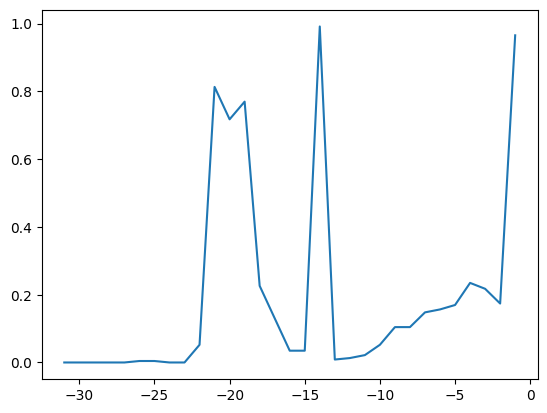

In [13]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = H_tests[layer]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    # cors = np.mean([eval_func(H) == H[0] for H in H_test])
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()